In [ ]:
import re
import uuid
from unicodedata import normalize
from string import punctuation
import warnings
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [ ]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [remover_acentos(palavra.lemma_)]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ["um", "uma", "não", "mais", "muito"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7) # , (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

In [ ]:
df_data = pd.read_csv("gnews.csv", sep=';', names=["title", "description"])
df_data.dropna(inplace=True)

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(HTML(df_data.iloc[index].sort_values(by=["title"]).to_html(index=False)))

In [30]:
def doc2token(doc):
    return TaggedDocument(tokenizer(doc), [str(uuid.uuid4())])

print("Tokenization...")
docs = set(df_data["title"])
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    documents_d2c = list(exc.map(doc2token, docs, chunksize=10))
print("Qtd documentos treino: ", len(documents_d2c))
print("Finished...")

Tokenization...
Qtd documentos treino:  3095
Finished...


In [31]:
documents_d2c[:10]

[TaggedDocument(words=['golpe', 'falso', 'criptomoeda', 'movimentar', 'mais', 'r$', 'milhao', 'brasil'], tags=['829a43f5-e577-4e91-8c0d-058dd44fcfa9']),
 TaggedDocument(words=['apos', 'ligar', 'urubu', 'flamadrid', 'rubronegros', 'veem', 'outro', 'lado', 'secador', 'final', 'libertador'], tags=['a7f6dd0c-3f17-4f3a-9ee0-a68b0ee3247f']),
 TaggedDocument(words=['michael', 'bloomberg', 'candidatar', 'presidencia', 'eua'], tags=['477faa14-1636-4939-9a27-75d8a2a0ff32']),
 TaggedDocument(words=['homem', 'atropelar', 'moto', 'agua', 'menino'], tags=['3d6c64bf-cea6-420e-b4b9-0d52cc8efa34']),
 TaggedDocument(words=['glamour', 'garcia', 'falir', 'fim', 'britney', 'emocionar', 'ver', 'noivo', 'querer'], tags=['72131cf7-f508-49a8-bdf7-4fb183d0b198']),
 TaggedDocument(words=['monstro', 'pantano', 'produtor', 'roteirista', 'falir', 'sobrar', 'plano', 'descartar', 'segundo', 'temporada'], tags=['b7642629-1ff0-4694-bf28-a88032988614']),
 TaggedDocument(words=['independent', 'spirit', 'awards', 'vidar',

In [32]:
dim = 1500
epochs = 200
M = 15000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 1500
Epochs       : 200
Infer Epochs : 15000


In [21]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=8, 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


In [22]:
X = d2v.docvecs.vectors_docs

In [23]:
kmin = 2
kmax = int(np.ceil((X.shape[0] * 0.1)))
kmax = 50 if kmax > 50 else kmax

print("Running Elbow...")
elbow_error = []
elbow_amount_clusters = 2
for _ in range(5):
    elbow_instance = elbow(1-cosine_similarity(X), kmin, kmax)
    elbow_instance.process()
    amc = elbow_instance.get_amount()
    if amc > elbow_amount_clusters:
        elbow_amount_clusters = amc
        elbow_error = elbow_instance.get_wce()

print("Running Silhouette...")
silhouette_amount_clusters = 0
search_instance = silhouette_ksearch(1-cosine_similarity(X), kmin, kmax, algorithm=silhouette_ksearch_type.KMEANS).process()
silhouette_amount_clusters = search_instance.get_amount()
scores = np.asarray(search_instance.get_scores())
scores[np.isnan(scores)] = -1

print("Elbow      Cluster : ", elbow_amount_clusters)
print("Silhouette Cluster : ", silhouette_amount_clusters)
qtd_cluster = elbow_amount_clusters if elbow_amount_clusters > silhouette_amount_clusters else silhouette_amount_clusters

Running Elbow...
Running Silhouette...
Elbow      Cluster :  17
Silhouette Cluster :  2


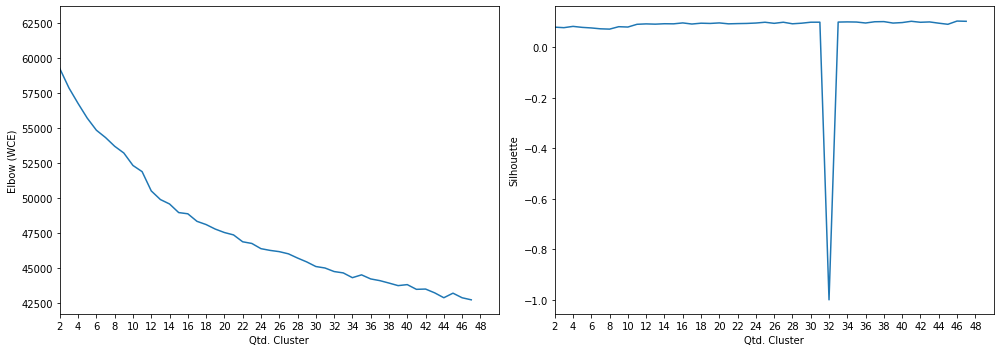

In [24]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(elbow_error)
plt.xticks(range(kmin, kmax, 2))
ax.set_xlim(kmin, kmax)
plt.xlabel("Qtd. Cluster")
plt.ylabel("Elbow (WCE)")
ax = plt.subplot(1, 2, 2)
plt.plot(scores)
plt.xticks(range(kmin, kmax, 2))
ax.set_xlim(kmin, kmax)
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [25]:
kclusterer = KMeansClusterer(
    qtd_cluster,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [26]:
docs = np.asarray(df_data["title"])

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
T = df.to_numpy()
index = np.random.choice(T.shape[0], 30, replace=False)
display(HTML(df.loc[index].sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Frases por cluster:


perguntas,cluster
"Black Friday já começou, mas só no calendário da Amazon",0
"Lois Lane e Clark Kent se encontram em nova imagem de ""Crise nas Infinitas Terras""",0
Brilhante: Michael Mann escreve ao realizador de Joker para elogiar o filme,1
5 frases de Miguel de Unamuno,1
"Black Friday: prepare-se para o futuro com cursos da Udemy a partir de R$ 19,99",1
"John le Carré, Jimmy Wales e Joanna Lumley dizem que não vão votar Corbyn por causa do antissemitismo",2
‘The Batman’: John Turturro é confirmado como icônico personagem,2
Uruguai escolhe no domingo entre austeridade e gastos sociais,2
Estudantes de Medicina escrevem à Ministra,3
Urologista realiza técnica inovadora no tratamento de doença da próstata,3


--------------------
Documentos por cluster:


C0,121
C1,169
C2,144
C3,157
C4,129
C5,181
C6,157
C7,170
C8,142
C9,106
C10,138
